# Classification with scikit-learn and Sagemaker

## Data exploration and preparation

### Prepare imports and data connections

The required packages are imported below. As can be seen, I have imported `pyathena` in order to connect to the reviews data. I have also imported `nltk`'s `stopwords` and `string`'s `punctuation` packages for data cleaning, as well as `pandas` and `numpy` for handling and transforming data.

In [ ]:
!pip3 install -U --user pandas statsmodels plotnine pyathena[pandas] future

In [2]:
import nltk

nltk.download("stopwords")

import pandas as pd
import numpy as np

from pyathena import connect
from string import punctuation
from sklearn import model_selection
from plotnine import *

from nltk.corpus import stopwords

stop = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Given that the reviews data are both large and stored in separate files per product category, I thought that the easiest way to work with them would be to read the data directly from the parquet files from Athena.

In [3]:
# Make connection to Athena database
conn = connect(
    aws_access_key_id="XXX",
    aws_secret_access_key="XXX",
    s3_staging_dir="s3://athena-jodie-burchell/",
    region_name="us-east-2",
)

I then confirmed that I had accessed the full dataset by checking the number of rows in the table. As the full dataset apparently contains around 130+ million observations, this number seemed correct.

In [4]:
pd.read_sql("SELECT COUNT(*) FROM amazonreviews.amazon_reviews_parquet", conn)

,_col0
0,160796570


### Data exploration

In order to get a sense of the data, I ran some initial queries. Firstly, I looked at the first 5 rows of the data to orientate myself with the dataset.

In [5]:
pd.read_sql("SELECT * FROM amazonreviews.amazon_reviews_parquet LIMIT 5", conn)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,year,product_category
0,US,37441986,R2H287L0BUP89U,B00CT780C2,473048287,Amazon.com eGift Cards,4,0,0,N,Y,Perfect Gift,I love giving my son amazon gift cards. That w...,16170,2014,Gift_Card
1,US,20676035,R1222MJHP5QWXE,B004LLILFA,361255549,"Amazon eGift Card - Thank You, Teacher (Chalkb...",5,1,1,N,Y,Five Stars,Great gift for outstanding teachers in our ass...,16391,2014,Gift_Card
2,US,45090731,R32ECJRNTB61K8,B004LLIL4G,307223063,Amazon eGift Card - Happy Birthday (Birds),5,0,0,N,Y,happy birthday card,gift cards from Amazon are always an appreciat...,16170,2014,Gift_Card
3,US,2207141,RLTEU3JZ1IJAA,B004LLILDM,87389551,Amazon eGift Card - Thank You,5,0,0,N,Y,Five Stars,gracias.,16391,2014,Gift_Card
4,US,15258,R1ZAX1TN66QOU6,B004LLIKVU,473048287,Amazon.com eGift Cards,5,0,0,N,Y,easy breezy,gift card was sent quickly and using it is a c...,16170,2014,Gift_Card


Given that the focus of this POC is classifying items into the product categories "Software", "Digital Software" and "Digital Video Games", I firstly got a count of the number of observations in each of these categories.

In [6]:
pd.read_sql(
            """
            SELECT product_category, COUNT(*) 
                FROM amazonreviews.amazon_reviews_parquet
                WHERE product_category IN ('Software', 'Digital_Software', 'Digital_Video_Games')
                GROUP BY product_category
            """,
    conn,
)

,product_category,_col1
0,Digital_Software,102084
1,Digital_Video_Games,145431
2,Software,342135


I also explored two other categories that may interact with the product category:
* **Marketplace:** Products may be classified differently in different markets. In addition, reviews and product titles may be in multiple languages.
* **Year:** Reviews about products may have different year ranges - for example, digital products may be newer than non-digital products.

To start, I created a crosstab of the number of reviews in each of the three categories by marketplace.

In [22]:
pd.read_sql(
            """
            SELECT product_category, marketplace, COUNT(*) 
                FROM amazonreviews.amazon_reviews_parquet
                WHERE product_category IN ('Software', 'Digital_Software', 'Digital_Video_Games')
                GROUP BY product_category, marketplace
                ORDER BY product_category
            """,
    conn,
)

,product_category,marketplace,_col2
0,Digital_Software,US,102084
1,Digital_Video_Games,US,145431
2,Software,US,341984
3,Software,UK,77
4,Software,JP,54
5,Software,DE,20


As can be seen, there are very few reviews for these product categories outside of the US, so it is safe to assume that the analysis can be restricted to just the US market.

I next examined the relationship between year and the three product categories:

In [8]:
year_data = pd.read_sql("""
                        SELECT product_category, year, COUNT(*) AS freq
                            FROM amazonreviews.amazon_reviews_parquet
                            WHERE product_category IN ('Software', 'Digital_Software', 'Digital_Video_Games')
                                AND marketplace = 'US'
                            GROUP BY product_category, year
                            ORDER BY product_category, year
                            """, conn)

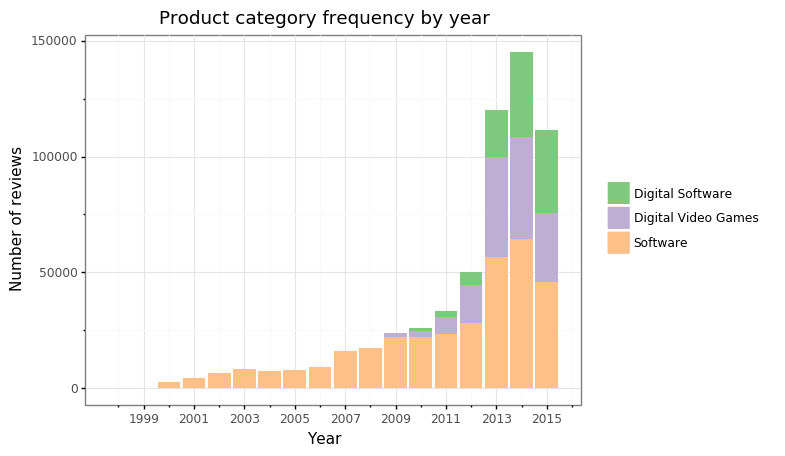

<ggplot: (8748219601949)>

In [23]:
cat_names = {
    "product_category": {
        "Digital_Software": "Digital Software",
        "Digital_Video_Games": "Digital Video Games",
    }
}
year_data.replace(cat_names, inplace=True)

(
    ggplot(year_data, aes("year", "freq", fill="product_category"))
    + geom_col()
    + scale_x_continuous(
        breaks=np.arange(year_data["year"].min() + 1, year_data["year"].max() + 1, 2)
    )
    + ggtitle("Product category frequency by year")
    + xlab("Year")
    + ylab("Number of reviews")
    + scale_fill_brewer(type="qual", palette="Accent")
    + theme_bw()
    + theme(legend_title=element_blank())
)

This graph demonstrates that 2010 was the first year that all three product categories were being used on the Amazon US site. As Digital Software and Digital Video Games categories didn't exist prior to this year, products that might have been otherwise placed in those categories during that time may have been categorised as Software. As such, I will limit my training data to 2010 onwards in order to remove this possible source of error.

Having now defined a training sample, I then turned to deciding what fields to use to extract features to train the model. I decided that two of the text fields were likely to contain the best information in the dataset to allow a model to tell the categories apart: 
* **review_body**: This field contains the body of reviews left for products on Amazon US. 
* **product_title**: This field is the title of each of the products on Amazon US.

Both of these fields contain a lot of category-specific words which would be informative features for a model. For example, the category Digital Video Games contains a number of useful terms in both fields, such as "Download" in the `product_title` field, and "game" and "graphics" in the `review_body` field.

In [13]:
pd.read_sql("""
            SELECT review_body, product_title
                FROM amazonreviews.amazon_reviews_parquet
                WHERE product_category = 'Digital_Video_Games'
                    AND marketplace = 'US'
                    AND year >= 2010
                LIMIT 3
            """
            , conn)

,review_body,product_title
0,thank you very much!!!!!!,Thief Gold [Download]
1,The only bad part is that you can't use the mo...,Doom 3 BFG Edition
2,came on time works great,Dungeon Siege 3


In addition, when inspecting the data I found a number of words that have different meanings as part of an n-gram compared to alone (for example, the word "final" clearly indicates a game in the context of "final fantasy", but may have a meaning unrelated to gaming in different contexts). As such I decided to also explore adding 2- and 3-grams as part of the modelling, as up to 3-grams appeared to capture most of the meaningful multiword terms (e.g., "recovery boot disc").

### Data sampling and cleaning

In order to extract the sample, I first checked the number of available observations per category after applying the marketplace and year filters.

In [14]:
pd.read_sql("""
            SELECT product_category, COUNT(*) as freq
                FROM amazonreviews.amazon_reviews_parquet
                WHERE product_category IN ('Software', 'Digital_Software', 'Digital_Video_Games')
                    AND marketplace = 'US'
                    AND year >= 2010
                GROUP BY product_category
            """
            , conn)

,product_category,freq
0,Digital_Video_Games,143864
1,Software,240322
2,Digital_Software,101762


As can be seen, the smallest category contains just over 100,000 observations. When training categorisation models, it is important to make sure that the observations in each category you are trying to predict are roughly equal, otherwise the model can bias towards predicting the category with the most observations. As such, I decided to randomly sample 100,000 observations from each of the three categories.

In [15]:
def read_in_sample_from_athena(feature_field: str, n: int) -> "pandas.DataFrame":
    """
    This function reads in a sample of n randomly selected observations from the Amazon Reviews 
    dataset, from each of the three prediction categories of interest (Software, Digital Software 
    and Digital Video Games). n should be selected to be smaller than the total number of 
    observations for the smallest of the 3 categories. 
    """

    software = pd.read_sql(
        f"""    
        SELECT {feature_field}, product_category
            FROM amazonreviews.amazon_reviews_parquet
            WHERE product_category = 'Software'
            AND marketplace = 'US'
            AND year >= 2010
            ORDER BY random()
            LIMIT {n}
        """,
        conn,
    )

    dig_software = pd.read_sql(
        f"""
        SELECT {feature_field}, product_category
            FROM amazonreviews.amazon_reviews_parquet
            WHERE product_category = 'Digital_Software'
            AND marketplace = 'US'
            AND year >= 2010
            ORDER BY random()
            LIMIT {n}
        """,
        conn,
    )

    dig_games = pd.read_sql(
        f"""
        SELECT {feature_field}, product_category
            FROM amazonreviews.amazon_reviews_parquet
            WHERE product_category = 'Digital_Video_Games'
            AND marketplace = 'US'
            AND year >= 2010
            ORDER BY random()
            LIMIT {n}
        """,
        conn,
    )

    csample = software.append(dig_software)
    csample = csample.append(dig_games)
    csample = csample.reset_index(drop=True)

    return csample

#### Cleaning the data

The next step was cleaning the text data in both the `review_body` and `product_title` fields. This involved:
* Dropping any rows containing NA;
* Converting all text to lowercase, so that the same word with different casing will not be treated as a separate feature by the model;
* Removing common EN stopwords, as they generally only add noise in Bag-of-Words models;
* Get rid of non-word tokens, as numbers are unlikely to be useful features in this context and punctuation needs to be stripped;
* Doing a final clean up, including getting rid of extra whitespace (otherwise it will be tokenised and treated as a model feature), deleting empty rows, and converting the fields to string.

In [16]:
def clean_text_data(
    csample: "pandas.DataFrame", feature_field: str, stopwords: list
) -> "pandas.DataFrame":
    """
    This function cleans the text data in preparation for modeling. The output is a cleansed string that is ready
    for tokenisation and vectorisation.
    """

    # Drop NAs
    csample[feature_field].dropna(inplace=True)

    # All words to lower
    csample[feature_field] = csample[feature_field].str.lower()

    # Remove stopwords
    pat = r"\b(?:{})\b".format("|".join(stop))
    csample[feature_field] = csample[feature_field].str.replace(pat, "")

    # Remove everything that is not a word
    csample[feature_field] = csample[feature_field].str.replace("[^a-z\s]", " ")

    # Replace all extra whitespace
    csample[feature_field] = csample[feature_field].str.replace(r"\s+", " ")
    csample[feature_field] = csample[feature_field].str.strip()

    # Convert all columns to string
    csample[feature_field] = csample[feature_field].apply(lambda x: np.str_(x))

    # Remove any entries that are empty after cleaning
    csample = csample[csample[feature_field] != ""]

    return csample

#### Create training, test and validation sets

In order to correctly train and test the models, I split the data into three datasets:
* **Train**: this dataset is used to train the models, and consists of 60% of the data;
* **Test**: this dataset is used to see how accurately the model predicts the categories on new data;
* **Validation**: this is a second test dataset, which is used when you are using the test dataset to assess the accuracy of multiple competing models. Having a validation dataset is best practice, as repeated model tuning and testing on the test dataset can lead to overfitting to this dataset. The validation dataset allows you to independently check the accuracy on a third, unseen dataset.

I used `sklearn`'s `model_selection` method to split the datasets, as this ensures an even distribution of the target categories in each dataset.

In [24]:
def split_into_test_train_validate(
    csample: "pandas.DataFrame", feature_field: str
) -> "pandas.DataFrame":
    """
    This function splits the data into test, train and validate sets using sklearn's model_selection function.
    """

    train_x, test_x, train_y, test_y = model_selection.train_test_split(
        csample[feature_field], csample["product_category"], test_size=0.2
    )

    train_x, val_x, train_y, val_y = model_selection.train_test_split(
        train_x, train_y, test_size=0.25
    )

    train = pd.concat([train_x, train_y], axis=1)
    test = pd.concat([test_x, test_y], axis=1)
    val = pd.concat([val_x, val_y], axis=1)

    return train, test, val

Finally, I ran the three above steps for the `review_body` and `product_title` fields, and saved their test, train and validation datasets to file in preparation for the model training.

In [18]:
%%time

# Prepare samples using the reviews as the features
reviews = read_in_sample_from_athena("review_body", 100000)
reviews = clean_text_data(reviews, "review_body", stop)
train_reviews, test_reviews, val_reviews = split_into_test_train_validate(reviews, "review_body")

CPU times: user 44.5 s, sys: 326 ms, total: 44.9 s
Wall time: 2min 25s


In [19]:
%%time

# Prepare samples using the product titles as the features
titles = read_in_sample_from_athena("product_title", 100000)
titles = clean_text_data(titles, "product_title", stop)
train_titles, test_titles, val_titles = split_into_test_train_validate(titles, "product_title")

CPU times: user 12.9 s, sys: 79.6 ms, total: 12.9 s
Wall time: 1min 25s


In [21]:
# Save all of the datasets to CSV

!mkdir data
# Reviews samples
train_reviews.to_csv("data/train_reviews.csv", header = True, index = False)
test_reviews.to_csv("data/test_reviews.csv", header = True, index = False)
val_reviews.to_csv("data/val_reviews.csv", header = True, index = False)
reviews.to_csv("data/full_reviews.csv", header = True, index = False)

# Products samples
train_titles.to_csv("data/train_titles.csv", header = True, index = False)
test_titles.to_csv("data/test_titles.csv", header = True, index = False)
val_titles.to_csv("data/val_titles.csv", header = True, index = False)
titles.to_csv("data/full_titles.csv", header = True, index = False)